In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import nltk
import re 
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/betulerkantarci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/betulerkantarci/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


37149
          Comment
Category         
-1           8277
 0          13042
 1          15830


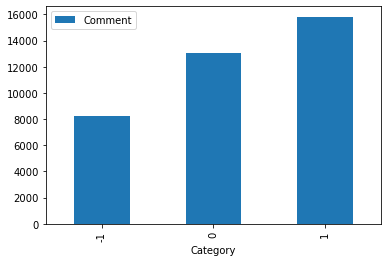

In [2]:
#Load the data into a DataF_rame
train_pd = pd.read_csv('reddit_comment_data.csv', encoding='latin-1', delimiter=";")
train = pd.DataFrame(train_pd, columns= ['Comment', 'Category'])
train=train.dropna().reset_index(drop=True)
print(len(train))
print(train.groupby('Category').count())
train.groupby('Category').count().plot.bar(ylim=0)
plt.show()



In [3]:
vocab = Counter()
count = 0
for i in train.Comment:
    for word in i.split(' '):
        vocab[word] += 1
    count += 1

vocab.most_common(20)

[('the', 57620),
 ('', 37828),
 ('and', 28922),
 ('that', 15363),
 ('this', 13480),
 ('for', 12977),
 ('you', 11728),
 ('are', 10564),
 ('not', 8693),
 ('they', 8649),
 ('have', 8380),
 ('with', 7843),
 ('but', 7265),
 ('will', 6903),
 ('was', 6368),
 ('people', 5536),
 ('what', 5278),
 ('india', 5175),
 ('all', 5129),
 ('has', 5094)]

In [4]:
lemmatizer = WordNetLemmatizer()

# Define function to lemmatize each word with its POS tag

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

count = 0
for i in train.Comment:

    comment = i

    pos_tagged = nltk.pos_tag(nltk.word_tokenize(comment))

    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_comment = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_comment.append(word)
        else:
            lemmatized_comment.append(lemmatizer.lemmatize(word, tag))
    lemmatized_comment = " ".join(lemmatized_comment)
    train.Comment[count] = lemmatized_comment
    
    count += 1
    
    
train.head()

,Comment,Category
0,family mormon have never try explain them they...,1
1,buddhism have very much lot compatible with ch...,1
2,seriously don say thing first all they win get...,-1
3,what you have learn yours and only yours what ...,0
4,for your own benefit you may want read live bu...,1


In [5]:
#Removing Stop Words

stop = stopwords.words('english')

count=0
for i in train.Comment:
    s=""
    for word in i.split(' '):
        if not word in stop:
            s =  s + ' ' + word 
    train.Comment[count] = s
    count += 1
    
train.head()

,Comment,Category
0,family mormon never try explain still stare p...,1
1,buddhism much lot compatible christianity esp...,1
2,seriously say thing first win get complex exp...,-1
3,learn want teach different focus goal wrap pa...,0
4,benefit may want read live buddha live christ...,1


In [6]:
#Removing Removing special characters and "trash"

def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
    
    return text


count = 0
for i in train.Comment:
    cleanData = preprocessor(i)
    train.Comment[count] = cleanData
    count += 1

train.head()

,Comment,Category
0,family mormon never try explain still stare p...,1
1,buddhism much lot compatible christianity esp...,1
2,seriously say thing first win get complex exp...,-1
3,learn want teach different focus goal wrap pa...,0
4,benefit may want read live buddha live christ...,1


In [7]:
count = 0
for i in train.Comment:
    if (len(i.split()) <= 5):
        train.drop(train.index[count],inplace=True)
        count -= 1
    count += 1

train = train.reset_index(drop=True)


train.head()

,Comment,Category
0,family mormon never try explain still stare p...,1
1,buddhism much lot compatible christianity esp...,1
2,seriously say thing first win get complex exp...,-1
3,learn want teach different focus goal wrap pa...,0
4,benefit may want read live buddha live christ...,1


In [8]:
len(train)

25429

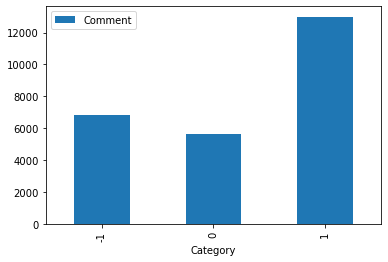

In [9]:
train.groupby('Category').count().plot.bar(ylim=0)
plt.show()

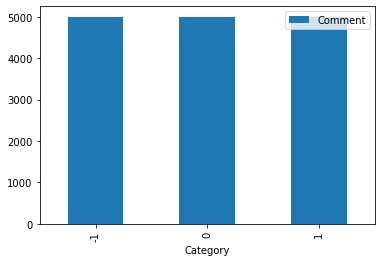

In [10]:
# Distributing data evenly 

count_p = 0;
count_z = 0;
count_n = 0;
count = 0;


clean_dist_data = pd.DataFrame(columns = train.columns)
clean_dist_data['Category'] = pd.to_numeric(clean_dist_data['Category'])

for i in train.Category:
    
    if(count_p < 5000 or count_z < 5000 or count_n < 5000):
        if(count_z < 5000 and  i == 0 ):
            count_z += 1
            clean_dist_data = clean_dist_data.append({'Comment' : train.Comment[count], 'Category' : train.Category[count]}, ignore_index = True)
        elif(count_p < 5000 and  i == 1 ):
            count_p += 1
            clean_dist_data = clean_dist_data.append({'Comment' : train.Comment[count], 'Category' : train.Category[count]}, ignore_index = True)
        elif (count_n < 5000 and i == -1):
            count_n += 1
            clean_dist_data = clean_dist_data.append({'Comment' : train.Comment[count], 'Category' : train.Category[count]}, ignore_index = True)
        count += 1 
        
clean_dist_data.groupby('Category').count().plot.bar(ylim=0)
plt.show()

In [12]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
    
n_gram_list = np.array([[1, 1], [2, 2], [3, 3], [1, 2], [1, 3]])
precision_array = [0,0,0,0,0]
recall_array = [0,0,0,0,0]
f1_array = [0,0,0,0,0]
f1onavg = [0,0,0,0,0]


X = clean_dist_data['Comment']
Y = clean_dist_data['Category']
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
for train_index, test_index in sss.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    count= 0;
        
    for i in n_gram_list:

        vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(i[0], i[1]))
        #final_features = vectorizer.fit_transform(clean_dist_data['Comment']).toarray()
        #final_features.shape

        pipeline = Pipeline([('vect', vectorizer),
                             ('chi',  SelectKBest(chi2, k='all')),
                             ('clf', LogisticRegression(random_state=0, max_iter=1000000))])

        model_LR = pipeline.fit(X_train, y_train)

        #with open('LogisticRegression.pickle', 'wb') as f:
            #pickle.dump(model_LR, f)

        ytest = np.array(y_test)
        prediction=model_LR.predict(X_test)

        # confusion matrix and classification report(precision, recall, F1-score)

        #print(confusion_matrix(ytest, prediction))
        #print(classification_report(ytest, prediction))
        
        ps = precision_score(ytest, prediction, average="weighted")
        precision_array[count] = precision_array[count] + ps
        rs = recall_score(ytest, prediction, average="weighted")
        recall_array[count] = recall_array[count] + rs
        fs= f1_score(ytest, prediction, average="weighted")
        f1_array[count] = f1_array[count] + fs
        fa= (2*ps*rs)/(ps+rs)
        f1onavg[count] =  f1onavg[count] + fa
        
        count += 1;
                           


In [13]:
# initialize list of lists
data = [['Unigram'], ['Bigram'], ['Trigram'], ['Unigram_Bigram'], ['Unigram_Bigram_Trigram']]

constant = 10
precision_array = [x / constant for x in precision_array]
recall_array = [x / constant for x in recall_array]
f1_array = [x / constant for x in f1_array]
f1onavg = [x / constant for x in f1onavg]

# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Model'])
df['Avg. Precision'] = precision_array
df['Avg. Recall'] = recall_array
df['Avg. F1-score'] = f1_array
df['F1 on Avg. P & Avg. R'] = f1onavg


  
# print dataframe.
print("Logistic Regression")
df


Logistic Regression


,Model,Avg. Precision,Avg. Recall,Avg. F1-score,F1 on Avg. P & Avg. R
0,Unigram,0.755663,0.752267,0.750534,0.753961
1,Bigram,0.511373,0.504300,0.492133,0.507810
2,Trigram,0.520431,0.361300,0.233598,0.426347
3,Unigram_Bigram,0.748264,0.746433,0.744936,0.747347
4,Unigram_Bigram_Trigram,0.748016,0.746300,0.744837,0.747157


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score

n_gram_list = np.array([[1, 1], [2, 2], [3, 3], [1, 2], [1, 3]])
precision_array_RF = [0,0,0,0,0]
recall_array_RF = [0,0,0,0,0]
f1_array_RF = [0,0,0,0,0]
f1onavg_RF = [0,0,0,0,0]

X = clean_dist_data['Comment']
Y = clean_dist_data['Category']
sss = StratifiedShuffleSplit(n_splits=10)
    
for train_index, test_index in sss.split(X, Y):
    count= 0;
    
    for i in n_gram_list:
        vectorizer = TfidfVectorizer(max_features=20000, min_df=7,stop_words=stopwords.words('english'), ngram_range=(i[0], i[1]))
        processed_features = vectorizer.fit_transform(X).toarray()
        
        X_train, X_test = processed_features[train_index], processed_features[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        model_RF = RandomForestClassifier(n_estimators=50, random_state=42)
        model_RF.fit(X_train, y_train)

        prediction=model_RF.predict(X_test)
        ps = precision_score(y_test, prediction, average="weighted")
        precision_array_RF[count] = precision_array_RF[count] + ps
        rs = recall_score(y_test, prediction, average="weighted")
        recall_array_RF[count] = recall_array_RF[count] + rs
        fs= f1_score(y_test, prediction, average="weighted")
        f1_array_RF[count] = f1_array_RF[count] + fs
        fa= (2*ps*rs)/(ps+rs)
        f1onavg_RF[count] =  f1onavg_RF[count] + fa
        
        count += 1;

        

In [37]:
# initialize list of lists
data = [['Unigram'], ['Bigram'], ['Trigram'], ['Unigram_Bigram'], ['Unigram_Bigram_Trigram']]

import pandas as pd

constant = 10
precision_array_RF = [x / constant for x in precision_array_RF]
recall_array_RF = [x / constant for x in recall_array_RF]
f1_array_RF = [x / constant for x in f1_array_RF]
f1onavg_RF = [x / constant for x in f1onavg_RF]

# Create the pandas DataFrame
df_RF = pd.DataFrame(data, columns=['Model'])
df_RF['Avg. Precision'] = precision_array_RF
df_RF['Avg. Recall'] = recall_array_RF
df_RF['Avg. F1-score'] = f1_array_RF
df_RF['F1 on Avg. P & Avg. R'] = f1onavg_RF


  
# print dataframe.
print("Random Forest")
df_RF

Random Forest


,Model,Avg. Precision,Avg. Recall,Avg. F1-score,F1 on Avg. P & Avg. R
0,Unigram,0.758468,0.758600,0.754356,0.758534
1,Bigram,0.508201,0.502067,0.488205,0.505107
2,Trigram,0.517495,0.354067,0.216768,0.419779
3,Unigram_Bigram,0.756747,0.756000,0.751320,0.756373
4,Unigram_Bigram_Trigram,0.754239,0.753733,0.749144,0.753985


In [38]:
df.to_excel("df_LG.xlsx")
df_RF.to_excel("df_RF.xlsx")